Let's query the CatSim database and pull down the stars in a given region and see what their spectra are.

Connect to fatboy with:

ssh -L 51433:fatboy.phys.washington.edu:1433 gateway.astro.washington.edu


If non-astro user, use simsuser@gateway.astro.washington.edu

Database schema at:  https://confluence.lsstcorp.org/display/SIM/Database+Schema


In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels import *
from lsst.sims.catUtils.exampleCatalogDefinitions import *
import numpy as np
from lsst.sims.utils import ObservationMetaData
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
from lsst.sims.photUtils import calcMagError_m5, PhotometricParameters
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/yoachim/gitRepos/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/yoachim/gitRepos/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [2]:
ra = 0.  # Degrees
dec = 0.  # Degrees
boundLength = 1. 
dbobj = CatalogDBObject.from_objid('allstars')
obs_metadata = ObservationMetaData(boundType='circle',pointingRA=ra,
                                   pointingDec=dec,boundLength=boundLength, mjd=5700)
t = dbobj.getCatalog('ref_catalog_star', obs_metadata=obs_metadata)

In [3]:
constraint = 'rmag < 18 and rmag > 15'
chunks = t.db_obj.query_columns(colnames=['magNorm', 'rmag', 'sedfilename', 'ebv', 'especid'], 
                                obs_metadata=obs_metadata,constraint=constraint, 
                                chunk_size=1000000)

/Users/yoachim/lsst/DarwinX86/sqlalchemy/2015_10.0-1-gaf5a1cb/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.5-x86_64.egg/sqlalchemy/sql/elements.py:3779: SAWarning: Textual SQL expression 'rmag < 18 and rmag > 15' should be explicitly declared as text('rmag < 18 and rmag > 15') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


In [4]:
for chunk in chunks:
    catalog = chunk

In [5]:
print catalog

[ (426037734, 18.416089294789845, 17.05723, ' lte035-5.0-1.0a+0.4.BT-Settl.spec.gz', 0.0323519, -1)
 (426038330, 18.290699525042417, 16.99824, ' lte037-5.5-1.0a+0.4.BT-Settl.spec.gz', 0.0308979, -1)
 (426034893, 19.3180890639283, 17.95176, ' lte034-4.5-1.0a+0.4.BT-Settl.spec.gz', 0.0388949, -1)
 ...,
 (818778168, 18.50200462579635, 17.8869787, 'km10_4500.fits_g00_4700', 0.0298073, -1)
 (588510793, 16.60674090182788, 15.8799033, 'km15_4250.fits_g00_4470', 0.0301708, -1)
 (818778743, 16.311396374180536, 16.0920467, 'km10_5500.fits_g15_5720', 0.0301708, -1)]


In [6]:
# OK, now I'd like to load up the spectra of one of the stars and apply the extinction so it's the full SED as it would be observed in space
import os

# the SEDs are stored in sub-directories of the sims_sed_library home
# directory.  defaultSpecMap is a dict-like class that maps from the
# sed filenames stored in the CatSim database to the relevant
# sub-directory
from lsst.sims.utils import defaultSpecMap

# get the sims_sed_library home directory
from lsst.utils import getPackageDir
sed_dir = getPackageDir('sims_sed_library')

from lsst.sims.photUtils import Sed, Bandpass

In [7]:
imsimBand = Bandpass()
imsimBand.imsimBandpass()  # this is how we normalize SEDs

(0, 10000)

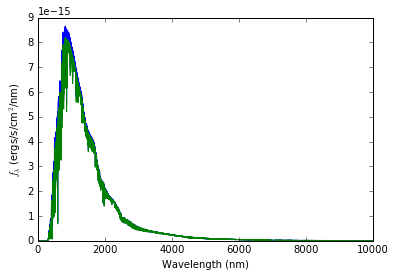

In [8]:
dex = 0 # index of the star whose spectrum we are generating

ss = Sed()
sed_name = os.path.join(sed_dir, defaultSpecMap[catalog['sedfilename'][dex]])
ss.readSED_flambda(sed_name)

# calculate the multiplicative normalization associated with 'magNorm'
# and multiply by that value.
# Note: if you wanted to normalize to a magnitude in a different band,
# you could do that by passing a different magnitude and bandpass
# into ss.calcFluxNorm()
fNorm = ss.calcFluxNorm(catalog['magNorm'][dex], imsimBand)
ss.multiplyFluxNorm(fNorm)

plt.plot(ss.wavelen, ss.flambda)
# set up some wavelength-dependent parameters for the dust model
# (note: even though the method is called CCMDust, this is actually
# applying the O'Donnell '94 dust model)
a_x, b_x = ss.setupCCMab()
ss.addCCMDust(a_x, b_x, ebv=catalog['ebv'][dex])

# ss will have member variables wavelen (in nm) and flambda, which is
# ergs/s/cm^2/nm
plt.plot(ss.wavelen, ss.flambda)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$f_\lambda$ (ergs/s/cm$^2$/nm)')
plt.xlim([0,10000])

In [9]:
# maybe now multiply by a throughput and calc LSST mags?
rband = Bandpass()
throughPath = os.path.join(getPackageDir('throughputs'), 'baseline')
bp =  np.loadtxt(os.path.join(throughPath, 'total_r.dat'),
                            dtype=zip(['wave', 'trans'], [float]*2))
rband.setBandpass(bp['wave'], bp['trans'])
print 'computed rmag', ss.calcMag(rband)
print 'from CatSim rmag', catalog['rmag'][dex]

computed rmag 17.0428202577
from CatSim rmag 17.05723


I'm going to guess that there might be a mis-match between the filter curves that were used when the database was constructed and the ones that are now the default.  


In [10]:
# In the future, just take a bunch of m5's from opsim
m5 = 24.
pp = PhotometricParameters()
print 'LSST mag, mag error = ', ss.calcMag(rband), calcMagError_m5(ss.calcMag(rband), rband, m5, pp)[0]

LSST mag, mag error =  17.0428202577 0.00515473440065


Now let's use MAF to load up some observations

In [11]:
dbfile = 'minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(dbfile)
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [12]:
bundleList = []
sql = 'filter="r"'
slicer = slicers.UserPointsSlicer(ra, dec)
metric = metrics.PassMetric(cols=['fiveSigmaDepth', 'expMJD'])
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bundleList.append(bundle)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

In [13]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint filter="r"
Found 538713 visits
Running:  ['opsim_Pass_fiveSigmaDepth_expMJD_r_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [14]:
star_mag = ss.calcMag(rband)
mag_err = [calcMagError_m5(star_mag, rband, m5, pp)[0] for m5 in bundle.metricValues[0]['fiveSigmaDepth']]

In [15]:
mag_err[0:10]

[0.0051526110405146095,
 0.0051497503541334004,
 0.0051527959946811568,
 0.0051663259809705837,
 0.0051540017415729455,
 0.0051591442110635356,
 0.0051484581039838093,
 0.0051481555176762887,
 0.0051535607997783926,
 0.0051591270433224709]